In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
from sklearn.utils import shuffle
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import transformers
from transformers import get_linear_schedule_with_warmup
import torch
import torch.nn as nn
from tqdm import tqdm
import html
import regex
from IPython.display import clear_output
import scipy

### Utility Functions

In [33]:
dataDict = pickle.load(open('redditSamples.pkl', 'rb'))
#fear, sadness, joy, anger
x = dataDict['samples'] 
y = dataDict['labels']
print(x[0], y[0])
def Inference(samples, model, disp=True):
    model.eval()
    tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-cased')
    all_probs=[]
    for batch_index, sample in enumerate(samples):

        inputs = tokenizer.encode_plus(sample, None,add_special_tokens=True,max_length = 512,pad_to_max_length=True)

        ids = torch.unsqueeze((torch.tensor(inputs["input_ids"], dtype=torch.long)).to(device, dtype=torch.long), 0)
        token_type_ids = (torch.tensor(inputs["token_type_ids"], dtype=torch.long)).to(device, dtype=torch.long)
        mask = torch.unsqueeze((torch.tensor(inputs['attention_mask'], dtype=torch.long)).to(device, dtype=torch.long), 0)

        # Zero out any previously calculated gradients
        model.zero_grad()
        #Forward Pass (faux inference)
        logits = model(ids, mask)
        clear_output(wait=True)
        #nn.Softmax(dim=1)
        probabilities = (logits).detach().cpu().numpy()[0]
        all_probs.append(probabilities)
        
        
    #fear, sadness, joy, anger

    if disp:
        for index, sample in enumerate(samples):
            print(f'Text: \"{sample}\"')
            #print(f'Logits: {logits[0].detach().cpu().numpy()}\n')
            ##order is Negative, Neutral, Positive
            percentages = all_probs[index]#may not work, delete code around if model actually softmaxes outputs
            #percentages = [100*num for num in all_probs[index]]
            #anger,disgust,fear,joy,sadness
            print(f'{100*percentages[0]:.2f}% anger, {100*percentages[1]:.2f}% disgust, {100*percentages[2]:.2f}% fear, {100*percentages[3]:.2f}% joy, {100*percentages[4]:.2f}% sadness')
    return all_probs
HASHTAG_CHARS = r"\p{L}\p{M}\p{Nd}_\u200c\u200d\ua67e\u05be\u05f3\u05f4\uff5e\u301c\u309b\u309c\u30a0\u30fb\u3003\u0f0b\u0f0c\u00b7"

def process_tweet(tweet):
    """Remove all URLs (e.g. www.xyz.com), hash tags (e.g. #topic), targets (@username)"""
    
    tweet = regex.sub(r"https?://t\.co/[a-zA-Z0-9]+",
                                "", tweet)

    tweet = regex.sub(r"(?:([^\w!#$%&*@＠]|^)|(?:^|[^\w+~.-])(?:rt|rT|Rt|RT):?)[@＠](\w{1,20}(?:/[a-zA-Z][\w-]{0,24})?)",
                                r"\1\2", tweet)

    tweet  = regex.sub(r"(^|\ufe0e|\ufe0f|[^&" +
                                HASHTAG_CHARS +
                                r"])[#＃]((?!\ufe0f|\u20e3)[" +
                                HASHTAG_CHARS +
                                r"]*[\p{L}\p{M}][" +
                                HASHTAG_CHARS +
                                r"]*)",
                                r"\1\2", tweet)

    tweet = regex.sub(r"\n+",
                                "\n", tweet)

    tweet = regex.sub(r"\s+",
                                " ", tweet).strip()

    tweet = html.unescape(tweet)

    return tweet

import matplotlib.pyplot
def graphLoss(losses):
    rang = np.linspace(1, len(losses), num=len(losses), dtype=int)
    plt.plot(rang, losses)



    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch')
    plt.show()
    
def getDataloaders(shuff=False, fileName='redditSamples.pkl', batch_size=4, val_fraction=1):
    dataDict = pickle.load(open(fileName, 'rb'))
    x = dataDict['samples'] 
    y = dataDict['labels']
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=23)


    train_dataset = DATALoader(
    data=X_train,
    target=y_train,
    max_length=512
    )

    train_data_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    num_workers=0,
    shuffle=shuff
    )

    #print(train_dataset[0])
    index = int(len(X_test)*val_fraction)
    val_dataset = DATALoader(
    data=X_test[:index],
    target=y_test[:index],
    max_length=512
    )

    val_data_loader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size,
    num_workers=0,
    shuffle=shuff
    )
    
    
    debug_set = DATALoader(
    data=X_test[:10],
    target=y_test[:10],
    max_length=512
    )

    debug_loader = torch.utils.data.DataLoader(
    debug_set, 
    batch_size=1,
    num_workers=0,
    shuffle=shuff
    )
    
    return train_data_loader, val_data_loader, debug_loader


This commercial really just reminded me what scumbags Verizon are [1, 1, 0, 0, 0]


### Classes

In [34]:
class DATALoader:
    def __init__(self, data, target, max_length):
        self.data = data
        self.target = target #make sure to convert the target into numerical values
        self.tokeniser = transformers.BertTokenizer.from_pretrained('bert-base-cased')
        self.truncation=True
        self.max_length = max_length
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        data = str(self.data[item])
        data = " ".join(data.split())
        inputs = self.tokeniser.encode_plus(
            data, 
            None,
            add_special_tokens=True,
            max_length = self.max_length,
            pad_to_max_length=True
            
        )
        
        ids = inputs["input_ids"]
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        padding_length = self.max_length - len(ids)
        ids = ids + ([0] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)

        
        #added code to allow for inference function (needs to accept inpout without targets)
        if self.target == []:
            targets = []
        else:
            targets = torch.tensor(self.target[item], dtype=torch.float)


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': targets
        }

from transformers import BertModel
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.layer1 = nn.Sequential(nn.Dropout(dropout), nn.Linear(768, 100), nn.ReLU(),nn.BatchNorm1d(100),nn.Linear(100, 5), nn.ReLU() )

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        
        out = self.layer1(pooled_output)

        return out

In [35]:
def Train(data_loader, model=None, optimizer=None, device=None, scheduler=None, epochs=None, loss_fn =None, val=True):
    print("Beginning training...\n")
    ep_losses = []
    best_loss=1
    for epoch_i in range(epochs):
        print(f"Epoch: {epoch_i+1}\n")


        # Put the model into the training mode
        model.train()
        losses = []
        for batch_index, sample in tqdm(enumerate(data_loader), total=len(data_loader)):

            
            #Load batch variabes to GPU
            ids = (sample["ids"]).to(device, dtype=torch.long)
            token_type_ids = (sample["token_type_ids"]).to(device, dtype=torch.long)
            mask = (sample["mask"]).to(device, dtype=torch.long)
            targets = (sample["targets"]).to(device, dtype=torch.float) 

            # Zero out any previously calculated gradients
            model.zero_grad()
            #Forward Pass (faux inference)
            logits = model(ids, mask)
            
            clear_output(wait=True)

            print(f"\n\n Logits:{logits}, \nTargets: {targets} \n\n")
            loss = loss_fn(logits, targets)

            print(f"LOSS: {loss}")
        
            #Backpropagate the loss
            loss.backward()
        
            #Using the internally stored gradients, update weights/biases according to optimizer
            optimizer.step()
            scheduler.step()
            
            #Save most performant model

            

             # Calculate the average loss over the entire training data
            #avg_train_loss = total_loss / len(data_loader)
            #print(f'Average Loss: {avg_train_loss}')
            
            losses.append(loss)
        if val:
            losses = validate(model, valDataLoader)
            avg_loss = np.mean(losses)
            ep_losses.append(avg_loss)
            if avg_loss > best_loss:
                        pickle.dump({'epoch': epoch_i,
                                    'model_state_dict': model.state_dict()}, open(MODELPATH, 'wb'))
                        print("\nModel Saved!")
                        best_loss = loss
    print(f"Average Validation Loss: {avg_loss}")
    return losses, ep_losses




In [27]:

MODELPATH = os.getcwd() +"\\model\\model.bin"
BATCH_SIZE = 8

In [37]:
trainDataLoader, valDataLoader, debugLoader = getDataloaders(False,fileName='redditSamples.pkl', batch_size=BATCH_SIZE, val_fraction = 0.1)

In [38]:
import time
import pickle
from transformers import AdamW, get_linear_schedule_with_warmup



useSavedModel = False
model = BertClassifier()
if useSavedModel:
        print("Loading Saved Model...")
        checkpoint = pickle.load(open(MODELPATH, 'rb'))
        model.load_state_dict(checkpoint['model_state_dict'])
        print("\nModel Loaded!")

        
l_r =1e-4
# l_r = 5e-5
#eps = 1e-8
eps = 1e-8
epochs=1
BATCH_SIZE=8
loss_fn = nn.MSELoss()

devName = 'cpu'


total_steps = len(trainDataLoader) * epochs
optimizer = AdamW(model.parameters(), lr=l_r, eps=eps)
device = torch.device(devName)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps) #0 is default for warmup steps

torch.cuda.empty_cache()
model.to(device)


losses, ep_losses = Train(trainDataLoader, model, optimizer, device, scheduler, epochs, loss_fn)






 Logits:tensor([[0.0000, 0.9176, 0.4498, 0.3190, 0.0000],
        [0.0000, 0.0000, 0.1219, 0.7910, 0.0000],
        [0.2189, 1.0043, 0.5207, 0.3633, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.1827, 0.1011],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.3237],
        [0.7334, 0.3633, 0.0000, 0.0588, 1.0572],
        [0.3469, 0.5016, 0.4491, 0.0000, 0.0000],
        [0.4177, 0.0000, 0.0252, 0.0000, 0.0382]], grad_fn=<ReluBackward0>), 
Targets: tensor([[0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.]]) 


LOSS: 0.24474266171455383


  0%|          | 0/2285 [00:22<?, ?it/s]


KeyboardInterrupt: 

In [40]:
samples = ["i hate dogs!", "I love pretty cats!",  "There will be heavy rainstorms tomorrow", 'fuck i am angry']
probs = Inference(samples, model)

Text: "i hate dogs!"
0.00% anger, 23.97% disgust, 0.60% fear, 0.00% joy, 0.00% sadness
Text: "I love pretty cats!"
0.00% anger, 24.62% disgust, 0.00% fear, 0.00% joy, 0.00% sadness
Text: "There will be heavy rainstorms tomorrow"
0.00% anger, 23.34% disgust, 0.05% fear, 0.00% joy, 0.29% sadness
Text: "fuck i am angry"
0.00% anger, 23.83% disgust, 1.65% fear, 0.00% joy, 0.01% sadness


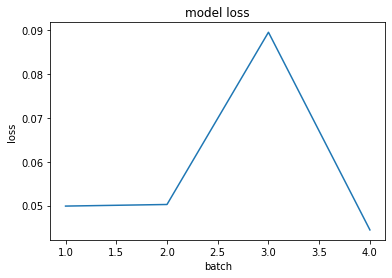

In [25]:
graphLoss(losses)

In [39]:
torch.save(model.state_dict(), MODELPATH)

In [23]:
stat_dict = torch.load(os.getcwd()+'/torchCHECKPT/model.pkl', map_location='cuda:0')
model = BertClassifier()
model.load_state_dict(stat_dict)
model.to('cuda')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [31]:
def validate(model, data_loader):

    #model.load_state_dict(torch.load(MODELPATH))
    device = 'cuda'
    model.eval()
    
    losses = []
    for batch_index, sample in tqdm(enumerate(data_loader), total=len(data_loader)):
        #Load batch variabes to GPU
        ids = (sample["ids"]).to(device, dtype=torch.long)
        token_type_ids = (sample["token_type_ids"]).to(device, dtype=torch.long)
        mask = (sample["mask"]).to(device, dtype=torch.long)
        targets = (sample["targets"]).to(device, dtype=torch.float) 

        # Zero out any previously calculated gradients
        model.zero_grad()
        #Forward Pass (faux inference)
        logits = model(ids, mask)

        clear_output(wait=True)

        loss = loss_fn(logits, targets)

        print(f"LOSS: {loss}")

        losses.append(loss.detach().cpu().numpy())
    return losses
